## Prepare data for LLM annotations 

This notebook takes in the Dutch election data as input, cleans it, removes unrelated cases. Then it takes a random 3-day sample for the purpose of validating the validation scheme. It then gets the lead and title of articles,extract proper nouns, and keywords, and finally it creates text pairs based on cosine similarity.  

* **input**: csv with documents
* **output**: sample of original csv/pickle file, text-pairs enriched with proper nouns, keywords, cosine similarity score 
* **embedding model used**: **GroNLP/bert-base-dutch-cased**

In [2]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import pickle
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
import spacy
import re
import matplotlib.pyplot as plt
import os

In [10]:
# Function to navigate up 'n' levels
def navigate_up(current_directory, levels):
    for _ in range(levels):
        current_directory = os.path.dirname(current_directory)
    return current_directory

# Get the current working directory
current_directory = os.getcwd()

# Specify the number of levels to navigate up (4 levels in this case)
levels_to_navigate = 3

# Navigate up 'levels_to_navigate' folders
parent_directory = navigate_up(current_directory, levels_to_navigate)

# Define the path to the data file
file_path = os.path.join(parent_directory, 'newspaper_data', 'Dutch_election_data (1).csv')

# Now you can open and read the CSV file using pandas
import pandas as pd

df = pd.read_csv(file_path)

In [18]:
#sort by date
df = df.sort_values(by = 'date')

# Get the number of unique dates
num_unique_dates = len(df['date'].unique())
num_unique_publishers = len(df['publisher'].unique())

# Print the result using an f-string
print(f"There are {num_unique_dates} dates in the DataFrame across {num_unique_publishers} publishers in the Netherlands. ")

There are 1597 dates in the DataFrame across 10 publishers in the Netherlands. 


In [19]:
#get unique publishers
df['publisher'].unique()

array(['De Telegraaf', 'NRC Handelsblad', 'Het Financieele Dagblad',
       'Trouw', 'Algemeen Dagblad', 'De Volkskrant', 'NU.nl', 'Nieuwsuur',
       'NOS nieuws', 'NOS liveblog'], dtype=object)

In [20]:
# Check for missing values in the 'text' column
missing_values = df['text'].isnull()

# Delete rows with missing values in the 'text' column
df = df[~missing_values]

In [21]:
#exclude texts that are recommendations for tv programs of news in short or a list of tips
#these often have non unique titles such as 'Tips'

# Find non-unique titles
non_unique_titles = df['title'][df['title'].duplicated(keep=False)]

# Print non-unique titles
print('Non-unique titles:')
print(len(non_unique_titles.unique()))

#print(non_unique_titles.unique())

#after manual observationexclude those rows where the title matches one of the below common headlines.

#remove all rows where title is just the program for some channels  
to_remove = ['NPO 2', 'NPO 1' ,'BBC 1' , 'BBC 2','TLC', 'Tips','kop tag with dummy text', 'Film- en televisietips', 'tv-ladder', 'TV-ladder', 'Best gelezen op fd.nl', 'MEER LEZEN']


Non-unique titles:
244


In [22]:
# Exclude rows with titles in the list
df= df[~df['title'].isin(to_remove)]

In [23]:
# Calculate text lengths
df['text_length'] = df['text'].astype(str).apply(len)
#get average length of text 
#Print the result using an f-string
average_text_length = df['text_length'].mean()
print(f"The average text length in this dataset of news articles is {average_text_length} characters.")

The average text length in this dataset of news articles is 3786.6435627530363 characters.


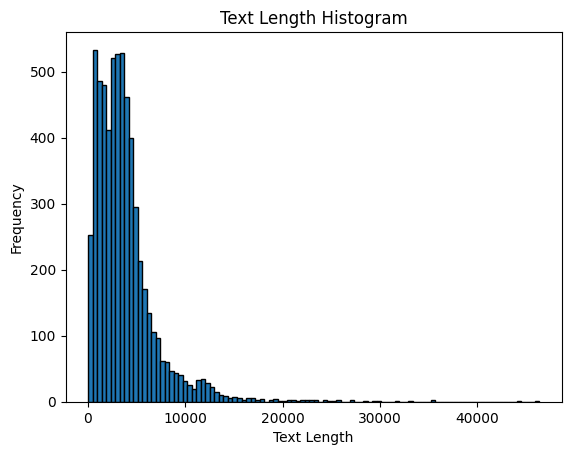

In [24]:
# Create a histogram
plt.hist(df['text_length'], bins=100, edgecolor='black')

plt.title('Text Length Histogram')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.show()

### Take a random sample of the full dataset

This is a candidate sample of information flows. In absense of an already annotated dataset, we get our candidate sample based on cosine similarity which was established as a good indicator of matches.

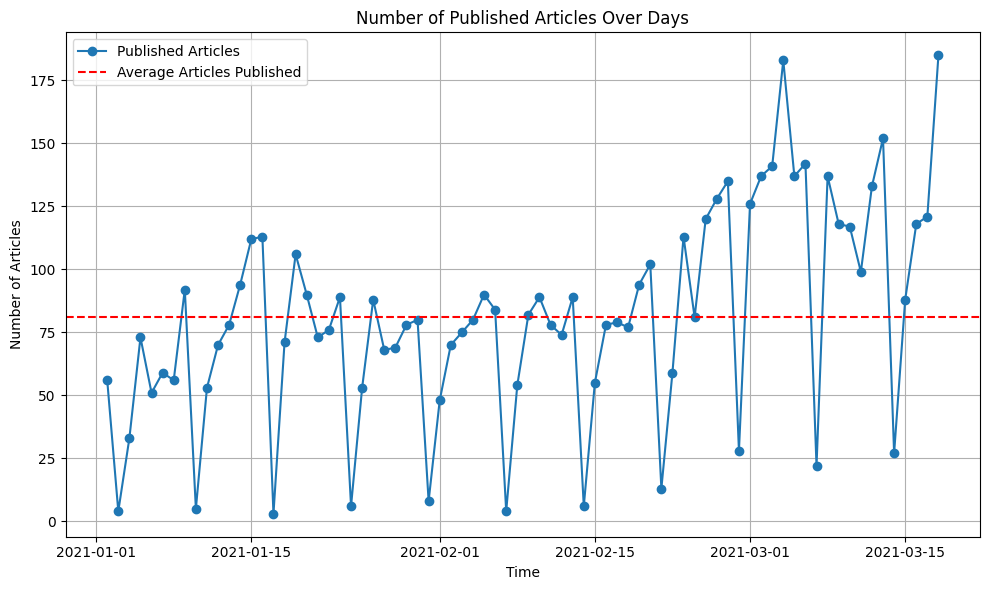

Average number of articles: 81.25
Time point(s) closest to average: 2021-02-24 00:00:00


In [26]:
df['date'] = pd.to_datetime(df['date'])  # Convert to datetime format
df_resampled = df.resample('D', on='date').count()

# Calculate the average number of articles
average_articles = df_resampled['id'].mean()

# Find the time point(s) closest to the average
closest_time_points = df_resampled.loc[df_resampled['id'].sub(average_articles).abs().idxmin()]

# Visualize the data with average line
plt.figure(figsize=(10, 6))
plt.plot(df_resampled.index, df_resampled['id'], marker='o', label='Published Articles')
plt.axhline(y=average_articles, color='r', linestyle='--', label='Average Articles Published')
plt.title('Number of Published Articles Over Days')
plt.xlabel('Time')
plt.ylabel('Number of Articles')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Ensures labels are not cut off
plt.show()
# Save the plot as a PDF file
#plt.savefig('figures/published_articles_plot.pdf')

print("Average number of articles:", average_articles)
print("Time point(s) closest to average:", closest_time_points.name)

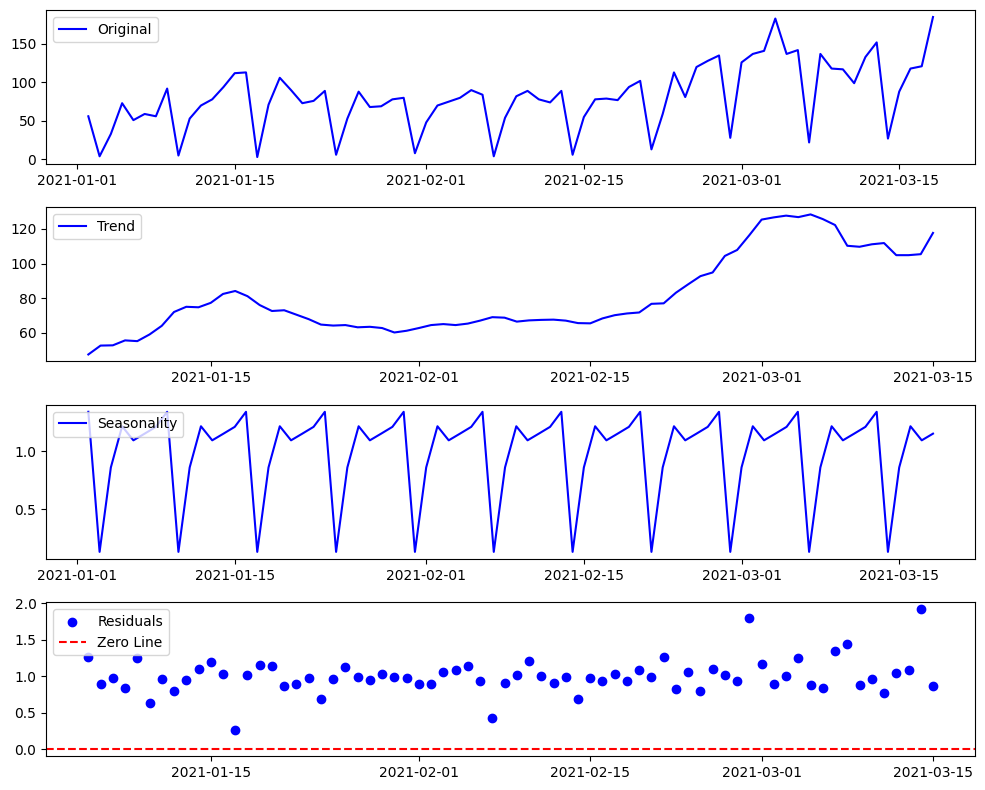

In [27]:
import statsmodels.api as sm

# Perform decomposition
decomposition = sm.tsa.seasonal_decompose(df_resampled['id'], model='multiplicative')

# Plot the decomposition components
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(df_resampled.index, df_resampled['id'], color='b',label='Original')
plt.legend(loc='upper left')
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, color='b',label='Trend')
plt.legend(loc='upper left')
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, color='b',label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(4, 1, 4)
plt.scatter(df_resampled.index, decomposition.resid, label='Residuals', color='b', marker='o')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Line')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [34]:
import random                                    #previous seed 1234567
from datetime import timedelta, datetime

# Set the random seed for reproducibility
random.seed(1234567)

# Assuming you have already imported and have a DataFrame 'df'

# Convert the 'date' column to datetime if it's not already
df['date'] = pd.to_datetime(df['date'])

# Get the list of unique dates in the DataFrame
unique_dates = df['date'].unique()

# Randomly select a starting date for the 3-day window
random_start_date = random.choice(unique_dates)

# Calculate the corresponding ending date
random_end_date = random_start_date + timedelta(days=2)

# Filter the DataFrame for rows within the randomly selected 3-day window
df1 = df[(df['date'] >= random_start_date) & (df['date'] <= random_end_date)]

In [35]:
df1

,id,publisher,title,author,text,Section,date,Byline,text_length
3864,3287580,Nieuwsuur,De uitzending van 27 februari: Verkiezingsspec...,NaN,In gesprek met Thierry Baudet\nSaai is het noo...,NaN,2021-02-27 15:06:47,NaN,755
3851,3287538,NOS liveblog,Ziekenhuisbezetting daalt met 55,NaN,De bezetting in de ziekenhuizen is de afgelope...,NaN,2021-02-27 15:20:11,NaN,397
3850,3287537,NOS liveblog,Eindhoven: kom niet naar de koning op 27 april,NaN,De koning bezoekt dit jaar op zijn verjaardag ...,NaN,2021-02-27 15:38:32,NaN,699
3849,3287536,NOS liveblog,"FvD'ers houden afstand in Oss, maar ondernemer...",NaN,Forum voor Democratie-leider Baudet hield vano...,NaN,2021-02-27 15:58:15,NaN,1020
3848,3287535,NOS liveblog,D66 pleit voor vaccinatiebewijs,NaN,D66-lijsttrekker Sigrid Kaag wil mensen die ge...,NaN,2021-02-27 16:40:42,NaN,1341
...,...,...,...,...,...,...,...,...,...
6023,6290506,NOS liveblog,'Opvallend en veelzeggend dat VVD en CDA hier ...,NaN,Een aantal partijen heeft op een persconferent...,NaN,2021-03-01 13:15:24,NaN,953
3807,3287398,NOS liveblog,'Opvallend en veelzeggend dat VVD en CDA hier ...,NaN,Een aantal partijen heeft op een persconferent...,NaN,2021-03-01 13:15:24,NaN,953
6041,6290581,NOS nieuws,Podcast De Stemming: Verkiezingscampagne maakt...,NaN,VVD-lijsttrekker Mark Rutte kwam niet lekker u...,NaN,2021-03-01 13:29:48,NaN,2092
6022,6290505,NOS liveblog,De Jonge: lijsttrekkers moeten in campagne beh...,NaN,Minister de Jonge van Volksgezondheid vindt he...,NaN,2021-03-01 14:33:22,NaN,871


### Clean the text 

In [468]:
nlp = spacy.load('nl_core_news_sm')

In [469]:
def clean_text(text):
    # Apply the Dutch language model
    doc = nlp(text)
    
    # Remove special characters and extra whitespace using regex
    cleaned_tokens = [re.sub(r'[^a-zA-Z0-9.,!?]', ' ', token.text).strip() if token.is_alpha or token.is_punct else token.text for token in doc]
    
    # Join tokens back into cleaned text
    cleaned_text = ' '.join(cleaned_tokens)
    
    # Replace consecutive newline characters with a single space
    cleaned_text = re.sub(r'\n+', ' ', cleaned_text)
    
    # Remove space before common punctuation (except newline)
    cleaned_text = re.sub(r'(?<=[^\n\s])\s*([.,!?])', r'\1', cleaned_text)
    
    # Remove extra spaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    
    # Strip leading and trailing spaces
    cleaned_text = cleaned_text.strip()
    
    return cleaned_text

# Apply the cleaning function to the 'text' column with tqdm progress bar
tqdm.pandas()  # Use tqdm with pandas
df1['cleaned_text'] = df1['text'].progress_apply(clean_text)

# Display the cleaned DataFrame
df1


100%|██████████| 142/142 [00:07<00:00, 20.02it/s]
/tmp/ipykernel_2650/1061925709.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['cleaned_text'] = df1['text'].progress_apply(clean_text)


,id,publisher,title,author,text,Section,date,Byline,text_length,cleaned_text
3864,3287580,Nieuwsuur,De uitzending van 27 februari: Verkiezingsspecial: in gesprek met Thierry Baudet / Corona-uitbra...,NaN,"In gesprek met Thierry Baudet\nSaai is het nooit, als het over Forum voor Democratie gaat. De pa...",NaN,2021-02-27 15:06:47,NaN,755,"In gesprek met Thierry Baudet Saai is het nooit, als het over Forum voor Democratie gaat. De par..."
3851,3287538,NOS liveblog,Ziekenhuisbezetting daalt met 55,NaN,De bezetting in de ziekenhuizen is de afgelopen dag afgenomen. Er lagen in totaal 1809 coronapat...,NaN,2021-02-27 15:20:11,NaN,397,De bezetting in de ziekenhuizen is de afgelopen dag afgenomen. Er lagen in totaal 1809 coronapat...
3850,3287537,NOS liveblog,Eindhoven: kom niet naar de koning op 27 april,NaN,"De koning bezoekt dit jaar op zijn verjaardag Eindhoven, in het kader van Koningsdag. De gemeent...",NaN,2021-02-27 15:38:32,NaN,699,"De koning bezoekt dit jaar op zijn verjaardag Eindhoven, in het kader van Koningsdag. De gemeent..."
3849,3287536,NOS liveblog,"FvD'ers houden afstand in Oss, maar ondernemers voelen toch ongemak",NaN,Forum voor Democratie-leider Baudet hield vanochtend een verkiezingsbijeenkomst in Oss en haalde...,NaN,2021-02-27 15:58:15,NaN,1020,Forum voor Democratie-leider Baudet hield vanochtend een verkiezingsbijeenkomst in Oss en haalde...
3848,3287535,NOS liveblog,D66 pleit voor vaccinatiebewijs,NaN,D66-lijsttrekker Sigrid Kaag wil mensen die gevaccineerd zijn meer toegang geven tot het openbar...,NaN,2021-02-27 16:40:42,NaN,1341,D66-lijsttrekker Sigrid Kaag wil mensen die gevaccineerd zijn meer toegang geven tot het openbar...
...,...,...,...,...,...,...,...,...,...,...
6023,6290506,NOS liveblog,'Opvallend en veelzeggend dat VVD en CDA hier niet staan',NaN,Een aantal partijen heeft op een persconferentie gereageerd op de doorrekeningen van het CPB en ...,NaN,2021-03-01 13:15:24,NaN,953,Een aantal partijen heeft op een persconferentie gereageerd op de doorrekeningen van het CPB en ...
3807,3287398,NOS liveblog,'Opvallend en veelzeggend dat VVD en CDA hier niet staan',NaN,Een aantal partijen heeft op een persconferentie gereageerd op de doorrekeningen van het CPB en ...,NaN,2021-03-01 13:15:24,NaN,953,Een aantal partijen heeft op een persconferentie gereageerd op de doorrekeningen van het CPB en ...
6041,6290581,NOS nieuws,Podcast De Stemming: Verkiezingscampagne maakt nog weinig los bij kiezer,NaN,"VVD-lijsttrekker Mark Rutte kwam niet lekker uit het RTL-verkiezingsdebat, constateren Joost Vul...",NaN,2021-03-01 13:29:48,NaN,2092,"VVD-lijsttrekker Mark Rutte kwam niet lekker uit het RTL-verkiezingsdebat, constateren Joost Vul..."
6022,6290505,NOS liveblog,De Jonge: lijsttrekkers moeten in campagne behoedzaam zijn over corona,NaN,Minister de Jonge van Volksgezondheid vindt het logisch dat lijsttrekkers in de verkiezingscampa...,NaN,2021-03-01 14:33:22,NaN,871,Minister de Jonge van Volksgezondheid vindt het logisch dat lijsttrekkers in de verkiezingscampa...


In [574]:
df1['publisher'].unique()

array(['Nieuwsuur', 'NOS liveblog', 'NU.nl', 'NOS nieuws',
       'Het Financieele Dagblad', 'De Telegraaf', 'Algemeen Dagblad',
       'Trouw', 'De Volkskrant', 'NRC Handelsblad'], dtype=object)

In [470]:
#save cleaned data as csv for later usage

df1.to_csv('newspaper_data/cleaned_sample.csv')

In [95]:
#df1 = pd.read_csv('newspaper_data/cleaned_sample.csv')

### Get only the lead of the text in order to comply with context window and transformer model req.

In [471]:
# Function to get the first 200 tokens of the text, ending at a sentence boundary, considering short first sentences
nlp.add_pipe("sentencizer")
def get_lead_tokens(text):
    doc = nlp(text)
    selected_tokens = []
    token_count = 0
    sentence_count = 0
    
    sentences = list(doc.sents)
    
    if len(sentences) > 0 and len(sentences[0].text.split()) <= 15:
        selected_tokens.extend(sentences[0])
        sentence_count += 1
    
    for token in sentences[sentence_count:]:
        if token_count + len(token) <= 200:
            selected_tokens.append(token)
            token_count += len(token)
            if token_count >= 200:
                break
    
    return ' '.join([token.text for token in selected_tokens])

# Apply the function to the DataFrame with tqdm
tqdm.pandas()

df1['lead'] = df1['cleaned_text'].progress_apply(get_lead_tokens)

100%|██████████| 142/142 [00:06<00:00, 22.22it/s]
/tmp/ipykernel_2650/3756218838.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['lead'] = df1['cleaned_text'].progress_apply(get_lead_tokens)


In [472]:
#to make sure we don't have any half sentences at the end
#Function to drop all extra text after the very last sentence to avpid half sentences
def drop_after_last_sentence(text):
    last_period_index = text.rfind('.')
    if last_period_index != -1:
        return text[:last_period_index + 1]  # Include the period in the output
    return text

df1['lead'] = df1['lead'].apply(drop_after_last_sentence)

/tmp/ipykernel_2650/3597997333.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['lead'] = df1['lead'].apply(drop_after_last_sentence)


In [473]:
#try of it worked
df1['lead'][6023]

"Een aantal partijen heeft op een persconferentie gereageerd op de doorrekeningen van het CPB en de PBL. En op het feit dat CDA en VVD n et op de persconferentie waren. Vooral de progressieve partijen staan hier, zei GroenLinks-leider Klaver. Opvallend en veelzeggend dat VVD en CDA hier niet staan. Hun programma's zijn sociaal slecht en brengen economische rampspoed, stelt PvdA-Kamerlid Nijboer. Dus ik snap wel dat ze hier niet staan. D66 benadrukt dat blijkt dat Nederland sterker en groener uit de crisis komt, als hun partijprogramma wordt uitgevoerd. De crux is dus dat het wel kan, veel ambities hebben en de economie een steun in de rug geven, zei Kamerlid Van Weyenberg. D66 heeft de CO2-reductie op 60 procent staan in 2030. Dat is relatief ambitieus, maar GroenLinks gaat er nog overheen. Wij komen uit op 63 procent, zei Klaver. Dat is belangrijk, want de uitvoering blijft altijd achter, daarom heb je overshoot nodig."

### Merge the title and the lead into one doc for more information

In [474]:
# Merge 'title' and 'first_200_words' columns with a separator ';'
df1['title_lead'] = df1['title'] + '; ' + df1['lead']

/tmp/ipykernel_2650/3166701124.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['title_lead'] = df1['title'] + '; ' + df1['lead']


In [475]:
df1['title_lead'][6023]

"'Opvallend en veelzeggend dat VVD en CDA hier niet staan'; Een aantal partijen heeft op een persconferentie gereageerd op de doorrekeningen van het CPB en de PBL. En op het feit dat CDA en VVD n et op de persconferentie waren. Vooral de progressieve partijen staan hier, zei GroenLinks-leider Klaver. Opvallend en veelzeggend dat VVD en CDA hier niet staan. Hun programma's zijn sociaal slecht en brengen economische rampspoed, stelt PvdA-Kamerlid Nijboer. Dus ik snap wel dat ze hier niet staan. D66 benadrukt dat blijkt dat Nederland sterker en groener uit de crisis komt, als hun partijprogramma wordt uitgevoerd. De crux is dus dat het wel kan, veel ambities hebben en de economie een steun in de rug geven, zei Kamerlid Van Weyenberg. D66 heeft de CO2-reductie op 60 procent staan in 2030. Dat is relatief ambitieus, maar GroenLinks gaat er nog overheen. Wij komen uit op 63 procent, zei Klaver. Dat is belangrijk, want de uitvoering blijft altijd achter, daarom heb je overshoot nodig."

### Extract named entities from the title + lead column and save in separate columns using spacy


In [476]:
# Function to extract proper nouns

nlp = spacy.load('nl_core_news_sm')

def extract_proper_nouns_spacy(text):
    doc = nlp(text)
    proper_nouns = [ent.text for ent in doc.ents if ent.label_ == 'PERSON' or ent.label_ == 'ORG']
    return ', '.join(proper_nouns)
# Apply the function to the DataFrame with tqdm
tqdm.pandas()
df1['proper_nouns_text'] = df1['title_lead'].progress_apply(extract_proper_nouns_spacy)

100%|██████████| 142/142 [00:02<00:00, 52.31it/s]
/tmp/ipykernel_2650/3891323376.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['proper_nouns_text'] = df1['title_lead'].progress_apply(extract_proper_nouns_spacy)


In [570]:
# Calculate the number of rows for each unique date
date_counts = df1['date'].value_counts()
date_counts

date
2021-03-01 00:00:00    73
2021-02-28 00:00:00     7
2021-03-01 10:59:13     2
2021-03-01 10:34:06     2
2021-03-01 12:06:47     2
2021-03-01 10:30:10     2
2021-03-01 13:15:24     2
2021-03-01 14:33:22     2
2021-03-01 12:57:21     2
2021-03-01 12:59:00     2
2021-03-01 07:12:10     2
2021-03-01 07:00:58     2
2021-03-01 01:19:49     2
2021-02-27 16:40:42     1
2021-02-27 16:47:06     1
2021-02-27 17:37:33     1
2021-02-27 17:18:07     1
2021-02-27 15:20:11     1
2021-02-27 15:38:32     1
2021-02-27 15:58:15     1
2021-02-27 15:06:47     1
2021-02-28 07:53:05     1
2021-02-28 06:52:07     1
2021-02-27 22:39:37     1
2021-02-27 22:36:38     1
2021-02-27 21:15:58     1
2021-02-27 21:52:54     1
2021-02-27 20:34:14     1
2021-02-27 20:30:26     1
2021-02-27 17:37:46     1
2021-02-27 20:11:46     1
2021-02-27 18:58:44     1
2021-02-27 18:49:28     1
2021-02-28 09:25:32     1
2021-02-28 10:01:22     1
2021-02-28 13:27:28     1
2021-02-28 13:43:06     1
2021-02-28 22:43:49     1
2021-02

### Extract keywords from title lead using KeyBERT

In [478]:
from keybert import KeyBERT
from transformers.pipelines import pipeline

hf_model = pipeline('feature-extraction', model='GroNLP/bert-base-dutch-cased')
kw_model = KeyBERT(model=hf_model)

Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [479]:
# Apply keyword extraction to each row in 'title_lead' column
def extract_keywords_from_text(text):
    keywords = kw_model.extract_keywords(str(text))
    return [keyword[0] for keyword in keywords]

df1['extracted_keywords'] = df1['title_lead'].progress_apply(extract_keywords_from_text)

100%|██████████| 142/142 [02:26<00:00,  1.03s/it]
/tmp/ipykernel_2650/3106075910.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['extracted_keywords'] = df1['title_lead'].progress_apply(extract_keywords_from_text)


In [480]:
#try if it worked
df1['extracted_keywords'][6023]

['rampspoed', 'doorrekeningen', 'reductie', 'overshoot', 'groener']

In [481]:
#save to pickle
df1.to_pickle('newspaper_data/title_lead_ner_keywords_sample.pkl')

### Use embedding model to get embeddings of the text 

We use the Dutch transformer model BERTje. On huggingface it's called `GroNLP/bert-base-dutch-cased'.

In [482]:
#with open('newspaper_data/title_lead_ner_keywords.pkl', 'rb') as f:
   # df= pickle.load(f)

model_name = 'GroNLP/bert-base-dutch-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

#corpus of article lead and title (the same usnit we're using throughout
article_corpus = df1['title_lead'].to_list()

Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [483]:
#function to get embeddings with BERTje
def get_embeddings(corpus):
    embeddings = []
    total_articles = len(corpus)

    for article in tqdm(corpus, desc='Computing embeddings', ncols=80):
        inputs = tokenizer(str(article), return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.squeeze().numpy())

    return embeddings

article_embeddings = get_embeddings(article_corpus)

Computing embeddings: 100%|███████████████████| 142/142 [00:05<00:00, 25.29it/s]


In [484]:
# Save the embeddings to a pickle file
with open('newspaper_data/title_lead_embeddings_sample.pkl', 'wb') as file:
    pickle.dump(article_embeddings, file)

#### Get similarities across the embeddings 

We do this so that we can use socine similarity to create text pairs we divide it into high matches, medium matches, and low matches and then proceed with the analysis.

In [543]:
import pickle
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
from tqdm import tqdm  

def load_embeddings_from_pickle(pickle_file):
    with open(pickle_file, "rb") as file:
        embeddings = pickle.load(file)
    return embeddings

def group_similar_texts(embeddings, texts, threshold_low, threshold_medium, threshold_high, df):
    similarity_matrix = cosine_similarity(embeddings)
    n_texts = len(texts)
    
    groups = {'low': [], 'medium': [], 'high': []}
    
    combination_pairs = list(combinations(range(n_texts), 2))
    for i, j in tqdm(combination_pairs, desc='Calculating Similarities'):
        similarity_score = similarity_matrix[i, j]


        if similarity_score >= threshold_high:
            groups['high'].append({
                'pair': (i, j),
                'similarity_score': similarity_score,
                'text1': texts[i],
                'text2': texts[j],
                'date1': df.iloc[i]['date'],
                'date2': df.iloc[j]['date'],
                'publisher1': df.iloc[i]['publisher'],
                'publisher2': df.iloc[j]['publisher'],
                'id1': df.iloc[i]['id'],
                'id2': df.iloc[j]['id'],
            })
        elif threshold_medium <= similarity_score < threshold_high:
            groups['medium'].append({
                'pair': (i, j),
                'similarity_score': similarity_score,
                'text1': texts[i],
                'text2': texts[j],
                'date1': df.iloc[i]['date'],
                'date2': df.iloc[j]['date'],
                'publisher1': df.iloc[i]['publisher'],
                'publisher2': df.iloc[j]['publisher'],
                'id1': df.iloc[i]['id'],
                'id2': df.iloc[j]['id'],
            })
        elif similarity_score >= threshold_low:
            groups['low'].append({
                'pair': (i, j),
                'similarity_score': similarity_score,
                'text1': texts[i],
                'text2': texts[j],
                'date1': df.iloc[i]['date'],
                'date2': df.iloc[j]['date'],
                'publisher1': df.iloc[i]['publisher'],
                'publisher2': df.iloc[j]['publisher'],
                'id1': df.iloc[i]['id'],
                'id2': df.iloc[j]['id'],
            })

    return groups

# Continue with the grouping process
threshold_low = 0.49
threshold_medium = 0.5
threshold_high = 0.7

texts = df1['title_lead'].tolist()

# Load the chunk embeddings from the pickle file
article_embeddings = load_embeddings_from_pickle('newspaper_data/title_lead_embeddings_sample.pkl')

groups = group_similar_texts(article_embeddings, texts, threshold_low, threshold_medium, threshold_high, df1)

# Process the groups and store the data in a DataFrame
data_rows = []

proper_nouns_list = df1['proper_nouns_text'].tolist()
keywords_list = df1['extracted_keywords'].tolist()

for group_name, group_data in groups.items():
    for item in tqdm(group_data, desc=f'Processing {group_name}'):
        chunk_pair = item['pair']
        similarity_score = item['similarity_score']
        text1 = item['text1']
        text2 = item['text2']
        date1 = item['date1']
        date2 = item['date2']
        publisher1 = item['publisher1']
        publisher2 = item['publisher2']
         # Add debugging statements here
        i = chunk_pair[0]
        j = chunk_pair[1]
        id1 = df1.iloc[i]['id']
        id2 = df1.iloc[j]['id']

        proper_nouns1 = proper_nouns_list[chunk_pair[0]]
        proper_nouns2 = proper_nouns_list[chunk_pair[1]]
        keywords1 = keywords_list[chunk_pair[0]]
        keywords2 = keywords_list[chunk_pair[1]]


        
        data_rows.append({
            'Similarity_Score': similarity_score,
            'Text1': text1,
            'Text2': text2,
            'Group': group_name,
            'Date1': date1,
            'Date2': date2,
            'Publisher1': publisher1,
            'Publisher2': publisher2,
            'ID1': id1,
            'ID2': id2,
            'proper_nouns1': proper_nouns1,
            'proper_nouns2': proper_nouns2,
            'keywords1': keywords1,
            'keywords2': keywords2
        })

# Create a DataFrame from the processed data
df2 = pd.DataFrame(data_rows)

# Set maximum column width for display
pd.set_option('display.max_colwidth', 100)

Calculating Similarities: 100%|██████████| 10011/10011 [00:03<00:00, 2751.93it/s]
Processing low: 0it [00:00, ?it/s]
Processing high: 100%|██████████| 8721/8721 [00:01<00:00, 8168.98it/s]


In [544]:
length = len(df2)
result = f"The length of dataframe with all possible matching pairs is {length}."
print(result)

The length of dataframe with all possible matching pairs is 10011.


In [545]:
df2

,Similarity_Score,Text1,Text2,Group,Date1,Date2,Publisher1,Publisher2,ID1,ID2,proper_nouns1,proper_nouns2,keywords1,keywords2
0,0.599136,De uitzending van 27 februari: Verkiezingsspecial: in gesprek met Thierry Baudet / Corona-uitbra...,Ziekenhuisbezetting daalt met 55; De bezetting in de ziekenhuizen is de afgelopen dag afgenomen ...,medium,2021-02-27 15:06:47,2021-02-27 15:20:11,Nieuwsuur,NOS liveblog,3287580,3287538,"Thierry Baudet, Thierry, Forum voor Democratie, Provinciale Statenverkiezingen, Thierry Baudet","IC, RIVM","[amsterdamse, schoolleiders, baudet, thierry, verkiezingsspecial]","[4605, besmettingen, ziekenhuisbezetting, coronapati, 525]"
1,0.696328,De uitzending van 27 februari: Verkiezingsspecial: in gesprek met Thierry Baudet / Corona-uitbra...,D66 pleit voor vaccinatiebewijs; D66-lijsttrekker Sigrid Kaag wil mensen die gevaccineerd zijn m...,medium,2021-02-27 15:06:47,2021-02-27 16:40:42,Nieuwsuur,NOS liveblog,3287580,3287535,"Thierry Baudet, Thierry, Forum voor Democratie, Provinciale Statenverkiezingen, Thierry Baudet","D66, Sigrid Kaag, Isra, Wel","[amsterdamse, schoolleiders, baudet, thierry, verkiezingsspecial]","[gevaccineerd, gevaccineerde, vaccinatiepaspoort, vaccinatiebewijs, coronatestuitslag]"
2,0.667074,De uitzending van 27 februari: Verkiezingsspecial: in gesprek met Thierry Baudet / Corona-uitbra...,Veel woede over schip met 1.800 koeien dat al twee maanden op zee dobbert; De woede van dierenre...,medium,2021-02-27 15:06:47,2021-02-27 16:47:06,Nieuwsuur,NU.nl,3287580,3288534,"Thierry Baudet, Thierry, Forum voor Democratie, Provinciale Statenverkiezingen, Thierry Baudet","ElBeik, Libi, Republiek Cyprus, ElBeik, Karim Allah","[amsterdamse, schoolleiders, baudet, thierry, verkiezingsspecial]","[blauwtongvirus, dierenrechtenorganisaties, turkije, famagusta, karim]"
3,0.602991,De uitzending van 27 februari: Verkiezingsspecial: in gesprek met Thierry Baudet / Corona-uitbra...,Vondelpark opnieuw dicht; Het Vondelpark is vanwege te grote drukte opnieuw gesloten . Dat meldt...,medium,2021-02-27 15:06:47,2021-02-27 17:18:07,Nieuwsuur,NOS liveblog,3287580,3287534,"Thierry Baudet, Thierry, Forum voor Democratie, Provinciale Statenverkiezingen, Thierry Baudet",,"[amsterdamse, schoolleiders, baudet, thierry, verkiezingsspecial]","[meldt, vondelpark, amsterdam, tilburg, toestroom]"
4,0.666908,De uitzending van 27 februari: Verkiezingsspecial: in gesprek met Thierry Baudet / Corona-uitbra...,Ook Texel begonnen met vaccineren; Als laatste Waddeneiland is ook Texel begonnen met vaccineren...,medium,2021-02-27 15:06:47,2021-02-27 17:37:33,Nieuwsuur,NOS liveblog,3287580,3287533,"Thierry Baudet, Thierry, Forum voor Democratie, Provinciale Statenverkiezingen, Thierry Baudet",NH,"[amsterdamse, schoolleiders, baudet, thierry, verkiezingsspecial]","[gevaccineerd, vaccineren, waddeneiland, gehandicaptenzorg, texelaars]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10006,0.871495,'Opvallend en veelzeggend dat VVD en CDA hier niet staan'; Een aantal partijen heeft op een pers...,De Jonge: lijsttrekkers moeten in campagne behoedzaam zijn over corona; Minister de Jonge van Vo...,high,2021-03-01 13:15:24,2021-03-01 14:33:22,NOS liveblog,NOS liveblog,3287398,6290505,"CDA, CPB, PBL, CDA, CDA, Kamerlid Van Weyenberg, ambitieus, GroenLinks",Jonge van Volksgezondheid,"[rampspoed, doorrekeningen, reductie, overshoot, groener]","[besmettingscijfers, rtl, holland, versoepelingen, pati]"
10007,0.871495,'Opvallend en veelzeggend dat VVD en CDA hier niet staan'; Een aantal partijen heeft op een pers...,De Jonge: lijsttrekkers moeten in campagne behoedzaam zijn over corona ; Minister de Jonge van V...,high,2021-03-01 13:15:24,2021-03-01 14:33:22,NOS liveblog,NOS liveblog,3287398,3287397,"CDA, CPB, PBL, CDA, CDA, Kamerlid Van Weyenberg, ambitieus, GroenLinks",Jonge van Volksgezondheid,"[rampspoed, doorrekeningen, reductie, overshoot, groener]","[besmettingscijfers, rtl, holland, versoepelingen, pati]"
10008,0.762449,Podcast 

In [546]:
df2.sort_values(by = 'Similarity_Score', ascending = False)

,Similarity_Score,Text1,Text2,Group,Date1,Date2,Publisher1,Publisher2,ID1,ID2,proper_nouns1,proper_nouns2,keywords1,keywords2
9956,1.000000,De uitzending van 1 maart: Gasvrij duurder dan verwacht / IC's vol in Hoorn / Genomineerden Libr...,De uitzending van 1 maart: Gasvrij duurder dan verwacht / IC's vol in Hoorn / Genomineerden Libr...,high,2021-03-01 12:06:47,2021-03-01 12:06:47,Nieuwsuur,Nieuwsuur,3287485,6290579,"Friese Garijp, Noord-Holland Noord, Jan Nieuwenburg","Friese Garijp, Noord-Holland Noord, Jan Nieuwenburg","[nieuwenburg, gasvrij, besmettingen, aardgasvrij, versoepelingen]","[nieuwenburg, gasvrij, besmettingen, aardgasvrij, versoepelingen]"
9875,1.000000,"Partijen willen hogere lasten voor bedrijven, blijkt uit doorrekeningen CPB; Tien partijen kieze...","Partijen willen hogere lasten voor bedrijven, blijkt uit doorrekeningen CPB; Tien partijen kieze...",high,2021-03-01 10:30:10,2021-03-01 10:30:10,NOS nieuws,NOS nieuws,3287448,6290557,"CPB, SGP, CPB, VVD, CDA, D66, GroenLinks, SP, PvdA, ChristenUnie, SGP, PVV, Partij voor de Diere...","CPB, SGP, CPB, VVD, CDA, D66, GroenLinks, SP, PvdA, ChristenUnie, SGP, PVV, Partij voor de Diere...","[lastenverzwaring, doorrekeningen, verkiezingsprogramma, overheidsuitgaven, 50plus]","[lastenverzwaring, doorrekeningen, verkiezingsprogramma, overheidsuitgaven, 50plus]"
9975,1.000000,Milieuclubs niet echt blij met doorrekeningen; Milieuorganisaties zijn teleurgesteld over de ver...,Milieuclubs niet echt blij met doorrekeningen; Milieuorganisaties zijn teleurgesteld over de ver...,high,2021-03-01 12:57:21,2021-03-01 12:57:21,NOS liveblog,NOS liveblog,6290507,3287399,"Milieuclubs, Kamers, CDA, GroenLinks, D66, PvdA, Greenpeace, D66, GroenLinks, PvdA, ChristenUnie...","Milieuclubs, Kamers, CDA, GroenLinks, D66, PvdA, Greenpeace, D66, GroenLinks, PvdA, ChristenUnie...","[greenpeace, nagestreefde, doorrekeningen, milieuclubs, klimaatakkoord]","[greenpeace, nagestreefde, doorrekeningen, milieuclubs, klimaatakkoord]"
9801,1.000000,Wekdienst 1/3: Verkiezingsprogramma's doorgerekend • Mbo-studenten naar school; Goedemorgen ! De...,Wekdienst 1/3: Verkiezingsprogramma's doorgerekend • Mbo-studenten naar school; Goedemorgen ! De...,high,2021-03-01 07:00:58,2021-03-01 07:00:58,NOS nieuws,NOS nieuws,6290568,3287459,"Planbureau, Baudet","Planbureau, Baudet","[wolkenvelden, klimaatdoelen, vriespunt, verkiezingsprogramma, leefomgeving]","[wolkenvelden, klimaatdoelen, vriespunt, verkiezingsprogramma, leefomgeving]"
10001,1.000000,'Opvallend en veelzeggend dat VVD en CDA hier niet staan'; Een aantal partijen heeft op een pers...,'Opvallend en veelzeggend dat VVD en CDA hier niet staan'; Een aantal partijen heeft op een pers...,high,2021-03-01 13:15:24,2021-03-01 13:15:24,NOS liveblog,NOS liveblog,6290506,3287398,"CDA, CPB, PBL, CDA, CDA, Kamerlid Van Weyenberg, ambitieus, GroenLinks","CDA, CPB, PBL, CDA, CDA, Kamerlid Van Weyenberg, ambitieus, GroenLinks","[rampspoed, doorrekeningen, reductie, overshoot, groener]","[rampspoed, doorrekeningen, reductie, overshoot, groener]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,0.544579,Dode en gewonde door zuurstofexplosie corona-afdeling Oekraïne; In een ziekenhuis in Tsjernivtsi...,"Laatste coronanieuws: 4729 nieuwe besmettingen, hoger dan weekgemiddelde; 18.50 uur | Aantal nie...",medium,2021-02-27 22:39:37,2021-02-28 00:00:00,NOS liveblog,Het Financieele Dagblad,3287529,3290679,"Oekra, Twintig, Oekra","RIVM, RIVM, Pati, RIVM, RIVM, RIVM mede bepaald","[tsjernivtsi, zaporizja, zuurstofexplosie, oekraïne, zuurstofleiding]","[meldt, 4605, coronabesmettingen, besmettingen, coronabesmetting]"
440,0.538848,Dode en gewonde door zuurstofexplosie corona-afdeling Oekraïne; In een ziekenhuis in Tsjernivtsi...,Vaccinatie-paspoort; Commentaar Hans van zon Beetje bij beetje maken politici de geesten rijp vo...,medium,2021-02-27 22:39:37,2021-03-01 00:00:00,NOS liveblog,Algemeen Dagblad,3287529,3286195,"Oekra, Twintig, Oekra","Commentaar, Hans van

In [547]:
# Filter out rows where ID1 and ID2 are the same
#df_filtered = df2[df2['ID1'] != df2['ID2']]

In [553]:
#df_filtered

In [557]:
def identical_matches(df):
    identical_matches = df[df['Similarity_Score'] > 0.999]
    return identical_matches
    #return len(identical_matches)

# Use the function to count identical matches
identical_matches = identical_matches(df2)
len(identical_matches)

# Remove identical matches from df2
df2 = df2[df2['Similarity_Score'] <= 0.999]

df2.sort_values(by = 'Similarity_Score', ascending = True)

,Similarity_Score,Text1,Text2,Group,Date1,Date2,Publisher1,Publisher2,ID1,ID2,proper_nouns1,proper_nouns2,keywords1,keywords2
481,0.502483,Dode en gewonde door zuurstofexplosie corona-afdeling Oekraïne; In een ziekenhuis in Tsjernivtsi...,Jozef Deleu: ‘Iets onder woorden brengen gaat sneller in een gedicht’; Wat maakt het leven de mo...,medium,2021-02-27 22:39:37,2021-03-01 00:00:00,NOS liveblog,NRC Handelsblad,3287529,3285657,"Oekra, Twintig, Oekra","Jozef Deleu, Jozef Deleu, Nederland zelfzuchtiger, Jozef Deleu, Lyrisch","[tsjernivtsi, zaporizja, zuurstofexplosie, oekraïne, zuurstofleiding]","[vlaams, zelfzuchtiger, bejaard, rekkem, jozef]"
9,0.523266,De uitzending van 27 februari: Verkiezingsspecial: in gesprek met Thierry Baudet / Corona-uitbra...,Dode en gewonde door zuurstofexplosie corona-afdeling Oekraïne; In een ziekenhuis in Tsjernivtsi...,medium,2021-02-27 15:06:47,2021-02-27 22:39:37,Nieuwsuur,NOS liveblog,3287580,3287529,"Thierry Baudet, Thierry, Forum voor Democratie, Provinciale Statenverkiezingen, Thierry Baudet","Oekra, Twintig, Oekra","[amsterdamse, schoolleiders, baudet, thierry, verkiezingsspecial]","[tsjernivtsi, zaporizja, zuurstofexplosie, oekraïne, zuurstofleiding]"
392,0.535320,Park Breda en terras in Gelderse Laren ontruimd; Aan het begin van de avond is park Valkenberg i...,Jozef Deleu: ‘Iets onder woorden brengen gaat sneller in een gedicht’; Wat maakt het leven de mo...,medium,2021-02-27 21:15:58,2021-03-01 00:00:00,NOS liveblog,NRC Handelsblad,3287530,3285657,Park Breda,"Jozef Deleu, Jozef Deleu, Nederland zelfzuchtiger, Jozef Deleu, Lyrisch","[nageleefd, vondelpark, amsterdamse, gelderland, kaarsjes]","[vlaams, zelfzuchtiger, bejaard, rekkem, jozef]"
440,0.538848,Dode en gewonde door zuurstofexplosie corona-afdeling Oekraïne; In een ziekenhuis in Tsjernivtsi...,Vaccinatie-paspoort; Commentaar Hans van zon Beetje bij beetje maken politici de geesten rijp vo...,medium,2021-02-27 22:39:37,2021-03-01 00:00:00,NOS liveblog,Algemeen Dagblad,3287529,3286195,"Oekra, Twintig, Oekra","Commentaar, Hans van zon Beetje, Angela Merkel, Mark Rutte, D66, Sigrid Kaag, Isra l","[tsjernivtsi, zaporizja, zuurstofexplosie, oekraïne, zuurstofleiding]","[vaccinatiepaspoort, gevaccineerde, herwonnen, europese, rutte]"
410,0.544579,Dode en gewonde door zuurstofexplosie corona-afdeling Oekraïne; In een ziekenhuis in Tsjernivtsi...,"Laatste coronanieuws: 4729 nieuwe besmettingen, hoger dan weekgemiddelde; 18.50 uur | Aantal nie...",medium,2021-02-27 22:39:37,2021-02-28 00:00:00,NOS liveblog,Het Financieele Dagblad,3287529,3290679,"Oekra, Twintig, Oekra","RIVM, RIVM, Pati, RIVM, RIVM, RIVM mede bepaald","[tsjernivtsi, zaporizja, zuurstofexplosie, oekraïne, zuurstofleiding]","[meldt, 4605, coronabesmettingen, besmettingen, coronabesmetting]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3389,0.948800,Hoogste bestuursrechter liet forse steken vallen in affaire kinderopvangtoeslagen; De affaire ro...,Hoogste bestuursrechter liet forse steken vallen in toeslagenaffaire; Pia Lokin-Sassen CDA De af...,high,2021-02-28 00:00:00,2021-03-01 00:00:00,Het Financieele Dagblad,Het Financieele Dagblad,3290695,3290608,"Andr Bosman, VVD, Tweede Kamer, Raad van State, Bart Jan van Ettekoven, Herman Tjeenk Willink, R...","Lokin-Sassen CDA, Andr Bosman, VVD, Tweede Kamer, Raad van State, Bart Jan van Ettekoven, Herman...","[overheidsinstantie, kinderopvangtoeslagen, ettekoven, dwingendrechtelijk, tjeenk]","[overheidsinstantie, kinderopvangtoeslagen, ettekoven, medewetgever, tjeenk]"
9999,0.995982,De Jonge: lijsttrekkers moeten in campagne behoedzaam zijn over corona ; Minister De Jonge van V...,De Jonge: lijsttrekkers moeten in campagne behoedzaam zijn over corona; Minister de Jonge van Vo...,high,2021-03-01 12:59:00,2021-03-01 14:33:22,NOS liveblog,NOS liveblog,3287414,6290505,Jonge van Volksgezondheid,Jonge van Volksgezondheid,"[besmettingscijfers, rtl, holland, versoepelingen, pati]","[besmettingscijfers, rtl, holland, versoep

#### Save final dataframe with text pairs for LLM's

We save the full dataframe, only highly matching pairs (>.70) as well as a sample of 100 from the highly matching pairs for validation validation purposes.

In [558]:
#save full output to a pickle file
df2.to_pickle('newspaper_data/title_lead_similarity_sample.pkl')

In [559]:
# Calculate the sample size as 1% of the total number of rows
sample_size_percent = 1
total_rows = len(df2)
sample_size = int((sample_size_percent / 100) * total_rows)

# Generate a random sample of size sample_size
sample = df2.sample(n=sample_size, random_state=42)  # Use a fixed random_state for reproducibility

# Save the sample as CSV for manual coding
sample.to_csv('newspaper_data/sample_1percent.csv', index=False)

sample.to_excel('newspaper_data/sample_1percent.xlsx', index=True)

# Save the updated DataFrame (excluding the sampled rows) as an Excel file to avoid formatting issues
remaining_data = df2.drop(sample.index)
remaining_data.to_excel("newspaper_data/remaining_data.xlsx", index=False)

# Save the updated DataFrame (excluding the sampled rows) as a CSV file
remaining_data.to_csv("newspaper_data/remaining_data.csv", index=False)


## Take validation sample for LLM assisted human validation task

This will be randomly selected 10% of the remaining data 

In [3]:
# Function to navigate up 'n' levels
def navigate_up(current_directory, levels):
    for _ in range(levels):
        current_directory = os.path.dirname(current_directory)
    return current_directory

# Get the current working directory
current_directory = os.getcwd()

# Specify the number of levels to navigate up (4 levels in this case)
levels_to_navigate = 3

# Navigate up 'levels_to_navigate' folders
parent_directory = navigate_up(current_directory, levels_to_navigate)

# Define the path to the data file
file_path = os.path.join(parent_directory, 'newspaper_data', 'remaining_data.csv')

# Now you can open and read the CSV file using pandas
import pandas as pd

df = pd.read_csv(file_path)

In [4]:
df

,Similarity_Score,Text1,Text2,Group,Date1,Date2,Publisher1,Publisher2,ID1,ID2,proper_nouns1,proper_nouns2,keywords1,keywords2
0,0.599136,De uitzending van 27 februari: Verkiezingsspec...,Ziekenhuisbezetting daalt met 55; De bezetting...,medium,2021-02-27 15:06:47,2021-02-27 15:20:11,Nieuwsuur,NOS liveblog,3287580,3287538,"Thierry Baudet, Thierry, Forum voor Democratie...","IC, RIVM","['amsterdamse', 'schoolleiders', 'baudet', 'th...","['4605', 'besmettingen', 'ziekenhuisbezetting'..."
1,0.696328,De uitzending van 27 februari: Verkiezingsspec...,D66 pleit voor vaccinatiebewijs; D66-lijsttrek...,medium,2021-02-27 15:06:47,2021-02-27 16:40:42,Nieuwsuur,NOS liveblog,3287580,3287535,"Thierry Baudet, Thierry, Forum voor Democratie...","D66, Sigrid Kaag, Isra, Wel","['amsterdamse', 'schoolleiders', 'baudet', 'th...","['gevaccineerd', 'gevaccineerde', 'vaccinatiep..."
2,0.667074,De uitzending van 27 februari: Verkiezingsspec...,Veel woede over schip met 1.800 koeien dat al ...,medium,2021-02-27 15:06:47,2021-02-27 16:47:06,Nieuwsuur,NU.nl,3287580,3288534,"Thierry Baudet, Thierry, Forum voor Democratie...","ElBeik, Libi, Republiek Cyprus, ElBeik, Karim ...","['amsterdamse', 'schoolleiders', 'baudet', 'th...","['blauwtongvirus', 'dierenrechtenorganisaties'..."
3,0.602991,De uitzending van 27 februari: Verkiezingsspec...,Vondelpark opnieuw dicht; Het Vondelpark is va...,medium,2021-02-27 15:06:47,2021-02-27 17:18:07,Nieuwsuur,NOS liveblog,3287580,3287534,"Thierry Baudet, Thierry, Forum voor Democratie...",NaN,"['amsterdamse', 'schoolleiders', 'baudet', 'th...","['meldt', 'vondelpark', 'amsterdam', 'tilburg'..."
4,0.666908,De uitzending van 27 februari: Verkiezingsspec...,Ook Texel begonnen met vaccineren; Als laatste...,medium,2021-02-27 15:06:47,2021-02-27 17:37:33,Nieuwsuur,NOS liveblog,3287580,3287533,"Thierry Baudet, Thierry, Forum voor Democratie...",NH,"['amsterdamse', 'schoolleiders', 'baudet', 'th...","['gevaccineerd', 'vaccineren', 'waddeneiland',..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9892,0.723135,'Opvallend en veelzeggend dat VVD en CDA hier ...,Podcast De Stemming: Verkiezingscampagne maakt...,high,2021-03-01 13:15:24,2021-03-01 13:29:48,NOS liveblog,NOS nieuws,3287398,6290581,"CDA, CPB, PBL, CDA, CDA, Kamerlid Van Weyenber...","Verkiezingscampagne, Mark Rutte, Joost Vulling...","['rampspoed', 'doorrekeningen', 'reductie', 'o...","['onderhandelingsmanoeuvre', 'verkiezingsdebat..."
9893,0.871495,'Opvallend en veelzeggend dat VVD en CDA hier ...,De Jonge: lijsttrekkers moeten in campagne beh...,high,2021-03-01 13:15:24,2021-03-01 14:33:22,NOS liveblog,NOS liveblog,3287398,6290505,"CDA, CPB, PBL, CDA, CDA, Kamerlid Van Weyenber...",Jonge van Volksgezondheid,"['rampspoed', 'doorrekeningen', 'reductie', 'o...","['besmettingscijfers', 'rtl', 'holland', 'vers..."
9894,0.871495,'Opvallend en veelzeggend dat VVD en CDA hier ...,De Jonge: lijsttrekkers moeten in campagne beh...,high,2021-03-01 13:15:24,2021-03-01 14:33:22,NOS liveblog,NOS liveblog,3287398,3287397,"CDA, CPB, PBL, CDA, CDA, Kamerlid Van Weyenber...",Jonge van Volksgezondheid,"['rampspoed', 'doorrekeningen', 'reductie', 'o...","['besmettingscijfers', 'rtl', 'holland', 'vers..."
9895,0.762449,Podcast De Stemming: Verkiezingscampagne maakt...,De Jonge: lijsttrekkers moeten in campagne beh...,high,2021-03-01 13:29:48,2021-03-01 14:33:22,NOS nieuws,NOS liveblog,6290581,6290505,"Verkiezingscampagne, Mark Rutte, Joost Vulling...",Jonge van Volksgezondheid,"['onderhandelingsmanoeuvre', 'verkiezingsdebat...","['besmettingscijfers', 'rtl', 'holland', 'vers..."


In [4]:
# Set a random seed for reproducibility
random_seed = 42  # You can use any integer value

# To take a reproducible random sample of 10% of the DataFrame's rows
final_sample= df.sample(frac=0.10, random_state=random_seed)

In [5]:
final_sample

,Similarity_Score,Text1,Text2,Group,Date1,Date2,Publisher1,Publisher2,ID1,ID2,proper_nouns1,proper_nouns2,keywords1,keywords2
8430,0.742020,Gods politiek; Stevo Akkerman Zonder enige waa...,"Partijen willen hogere lasten voor bedrijven, ...",high,2021-03-01 00:00:00,2021-03-01 10:30:10,Trouw,NOS nieuws,3285316,6290557,"Stevo Akkerman Zonder, ChristenUnie, GPV, Albe...","CPB, SGP, CPB, VVD, CDA, D66, GroenLinks, SP, ...","['verkiezingsaffiche', 'albertus', 'heilloze',...","['lastenverzwaring', 'doorrekeningen', 'verkie..."
4058,0.771580,Volgens helft FVD-kiezers is corona een complo...,Wilders in de schijnwerpers; Wilders in de sch...,high,2021-02-28 09:25:32,2021-03-01 00:00:00,NU.nl,De Telegraaf,3288497,3286364,"Forum voor Democratie-kiezers, Ipsos","Wilders, Mark Rutte, Sigrid Kaag D66, Wilders,...","['ipsos', 'coronavirus', 'nieuwsuur', 'nederla...","['diversiteitsquota', 'ronald', 'rtl', 'zit', ..."
2794,0.786675,Van eerste besmetting tot avondklok: het coron...,De Jonge: lijsttrekkers moeten in campagne beh...,high,2021-02-27 20:34:14,2021-03-01 12:59:00,NU.nl,NOS liveblog,3288518,6290523,"Mark Rutte, Tweede Kamer",Jonge van Volksgezondheid,"['brabantse', 'sneltreinvaart', 'coronabesmett...","['besmettingscijfers', 'rtl', 'holland', 'vers..."
4822,0.750815,Moet er meer in de zorg geïnvesteerd worden?; ...,Baudet: corona niet bewust wereld in geslinger...,high,2021-02-28 21:37:41,2021-03-01 10:34:06,NOS liveblog,NOS nieuws,3287480,6290556,"Hoekstra CDA, SP, juist","Baudet, Forum voor Democratie-voorman Thierry ...","['obesitas', 'marijnissen', 'vraagstuk', 'deba...","['virussen', 'chinees', 'ebolavirus', 'ingesto..."
621,0.605653,Laatste coronanieuws: 4729 nieuwe besmettingen...,Lezersbrieven; EEN JAAR CORONA | Ik hoop dat w...,medium,2021-02-28 00:00:00,2021-03-01 00:00:00,Het Financieele Dagblad,Algemeen Dagblad,3290679,3286194,"RIVM, RIVM, Pati, RIVM, RIVM, RIVM mede bepaald","Lezersbrieven, AD, Baudet, Ineke Pappers-Roode...","['meldt', '4605', 'coronabesmettingen', 'besme...","['strijensas', 'roodenrijs', 'vlaardingen', 't..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8437,0.774394,Gods politiek; Stevo Akkerman Zonder enige waa...,Milieuclubs niet echt blij met doorrekeningen;...,high,2021-03-01 00:00:00,2021-03-01 12:57:21,Trouw,NOS liveblog,3285316,6290507,"Stevo Akkerman Zonder, ChristenUnie, GPV, Albe...","Milieuclubs, Kamers, CDA, GroenLinks, D66, Pvd...","['verkiezingsaffiche', 'albertus', 'heilloze',...","['greenpeace', 'nagestreefde', 'doorrekeningen..."
8039,0.844178,Loonkloof is nog altijd niet gedicht; Stond he...,"De doorrekening van de verkiezingsprogramma's,...",high,2021-03-01 00:00:00,2021-03-01 07:12:10,Algemeen Dagblad,NOS nieuws,3286188,6290567,"Loonkloof, VVD, CDA, D66, GroenLinks, euro, SP",Planbureau,"['loonkloof', 'eindsalaris', 'salarissen', 'st...","['klimaatdoelen', 'doorrekeningen', 'verkiezin..."
594,0.682143,Laatste coronanieuws: 4729 nieuwe besmettingen...,"Manifestatie FvD afgebroken, aanhangers bekeur...",medium,2021-02-28 00:00:00,2021-02-28 13:43:06,Het Financieele Dagblad,NOS liveblog,3290679,3287500,"RIVM, RIVM, Pati, RIVM, RIVM, RIVM mede bepaald","Forum voor Democratie, Thierry Baudet","['meldt', '4605', 'coronabesmettingen', 'besme...","['meldt', 'tegendemonstranten', 'opruiing', 'b..."
4896,0.845664,Een boer versus D66-leider Kaag over de halver...,Scholen vragen zich af: waar blijven de snelte...,high,2021-02-28 21:41:40,2021-03-01 00:00:00,NOS liveblog,Trouw,3287479,3285335,D66,"CNV, Kleuters, CNV, AOb, Algemene Vereniging S...","['stikstofreductie', 'veestapel', 'langsgaan',...","['sneltesten', 'sneltests', 'amsterdamse', 'sc..."


In [6]:
# Save the final sample as excel file
final_sample.to_excel("final_sample.xlsx", index=False)

# Save the final sample as csv file
final_sample.to_csv("final_sample.csv", index=False)

### Get overlap sample

In [9]:
# Set a random seed for reproducibility
random_seed = 42  # You can use any integer value

# To take a reproducible random sample of 10% of the DataFrame's rows
overlap_sample= df.sample(frac=0.01, random_state=random_seed)

In [10]:
overlap_sample

,Similarity_Score,Text1,Text2,Group,Date1,Date2,Publisher1,Publisher2,ID1,ID2,proper_nouns1,proper_nouns2,keywords1,keywords2
8430,0.742020,Gods politiek; Stevo Akkerman Zonder enige waa...,"Partijen willen hogere lasten voor bedrijven, ...",high,2021-03-01 00:00:00,2021-03-01 10:30:10,Trouw,NOS nieuws,3285316,6290557,"Stevo Akkerman Zonder, ChristenUnie, GPV, Albe...","CPB, SGP, CPB, VVD, CDA, D66, GroenLinks, SP, ...","['verkiezingsaffiche', 'albertus', 'heilloze',...","['lastenverzwaring', 'doorrekeningen', 'verkie..."
4058,0.771580,Volgens helft FVD-kiezers is corona een complo...,Wilders in de schijnwerpers; Wilders in de sch...,high,2021-02-28 09:25:32,2021-03-01 00:00:00,NU.nl,De Telegraaf,3288497,3286364,"Forum voor Democratie-kiezers, Ipsos","Wilders, Mark Rutte, Sigrid Kaag D66, Wilders,...","['ipsos', 'coronavirus', 'nieuwsuur', 'nederla...","['diversiteitsquota', 'ronald', 'rtl', 'zit', ..."
2794,0.786675,Van eerste besmetting tot avondklok: het coron...,De Jonge: lijsttrekkers moeten in campagne beh...,high,2021-02-27 20:34:14,2021-03-01 12:59:00,NU.nl,NOS liveblog,3288518,6290523,"Mark Rutte, Tweede Kamer",Jonge van Volksgezondheid,"['brabantse', 'sneltreinvaart', 'coronabesmett...","['besmettingscijfers', 'rtl', 'holland', 'vers..."
4822,0.750815,Moet er meer in de zorg geïnvesteerd worden?; ...,Baudet: corona niet bewust wereld in geslinger...,high,2021-02-28 21:37:41,2021-03-01 10:34:06,NOS liveblog,NOS nieuws,3287480,6290556,"Hoekstra CDA, SP, juist","Baudet, Forum voor Democratie-voorman Thierry ...","['obesitas', 'marijnissen', 'vraagstuk', 'deba...","['virussen', 'chinees', 'ebolavirus', 'ingesto..."
621,0.605653,Laatste coronanieuws: 4729 nieuwe besmettingen...,Lezersbrieven; EEN JAAR CORONA | Ik hoop dat w...,medium,2021-02-28 00:00:00,2021-03-01 00:00:00,Het Financieele Dagblad,Algemeen Dagblad,3290679,3286194,"RIVM, RIVM, Pati, RIVM, RIVM, RIVM mede bepaald","Lezersbrieven, AD, Baudet, Ineke Pappers-Roode...","['meldt', '4605', 'coronabesmettingen', 'besme...","['strijensas', 'roodenrijs', 'vlaardingen', 't..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,0.800843,Veel woede over schip met 1.800 koeien dat al ...,D66-leider Kaag wil alvast open voor wie gevac...,high,2021-02-27 16:47:06,2021-03-01 00:00:00,NU.nl,Trouw,3288534,3285327,"ElBeik, Libi, Republiek Cyprus, ElBeik, Karim ...","Sigrid Kaag, voetbalstadions, D66, D66","['blauwtongvirus', 'dierenrechtenorganisaties'...","['gevaccineerd', 'gevaccineerde', 'sneltesten'..."
1470,0.718559,Eindhoven: kom niet naar de koning op 27 april...,Kaag versus Wilders: U met uw zielige Zwarte P...,high,2021-02-27 15:38:32,2021-02-28 22:10:45,NOS liveblog,NOS liveblog,3287537,3287476,NaN,"Wilders, Zwarte Piet!, Zwarte Piet, Zwarte Pie...","['koningsdag', 'limburgse', 'alsnog', 'oranjef...","['marokkaanse', 'kamervoorzitter', 'rutte', 'e..."
3078,0.816701,Baudet beschuldigd van kiezersbedrog door koms...,Het RTL-debat zal hoogstens herinnerd worden o...,high,2021-02-27 22:36:38,2021-03-01 00:00:00,Nieuwsuur,NRC Handelsblad,3287577,3285661,"Forum voor Democratie, Baudet, CDA, VVD, Pasca...","Kristie Rongen, RTL, Eva Jinek, VVD, CDA, Mark...","['verkiezingsretoriek', 'partijkartelbestrijde...","['nabeschouwde', 'ingestudeerde', 'toeslagenaf..."
39,0.644809,De uitzending van 27 februari: Verkiezingsspec...,kruiswoordtest 5898; Horizontaal 1deze Europea...,medium,2021-02-27 15:06:47,2021-03-01 00:00:00,Nieuwsuur,Trouw,3287580,3285386,"Thierry Baudet, Thierry, Forum voor Democratie...","Roger Federer voor miljoenen, SP, VVD, 18coupl...","['amsterdamse', 'schoolleiders', 'baudet', 'th...","['europeanen', 'geactualiseerde', 'anagr', 'wi..."


In [11]:
# Save the final sample as excel file
overlap_sample.to_excel("overlap_sample.xlsx", index=False)

# Save the final sample as csv file
overlap_sample.to_csv("overlap_sample.csv", index=False)